In [1]:
import sys
import importlib
sys.path.insert(0, './hxetda/')
import hxetda
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_recall_fscore_support
from sklearn.utils import class_weight

In [ ]:
# Let's import preprocess our variable star data
scaler = StandardScaler()
vertices = np.asarray(['Object','**', 'AGB*', 'AGN',  'Ae*', 
			'BLLac', 'BYDra', 'Be*', 'BlueStraggler','C*',  
			'Cepheid','EB*', 'EllipVar', 'Em*', 'Eruptive*', 
	'HB*', 'HotSubdwarf', 'Irregular_V*', 'LPV*', 'Mira', 
'OH/IR', 'Orion_V*', 'Pec*','PulsV*', 'PulsV*RVTau', 
'PulsV*WVir','PulsV*delSct', 'QSO', 'RGB*', 'RRLyr',
 'RSCVn', 'RedSG*', 'RotV*', 'S*', 'SB*', 
 'Seyfert','Star', 'TTau*','V*', 'WD*', 
 'YSO', 'deltaCep', 'gammaDor', 'low-mass*', 'SG*','EV*','MS','Ma*', 'Blazar','CV'],dtype=str)

# I am adding some conversions here for events which are either "candidates" or have <5 objects
conversions = {'AGN_Candidate':'AGN', 'Blazar_Candidate':'Blazar',
				'Candidate_AGB*':'AGB*', 'Candidate_Ae*':'Ae*',
				'Candidate_C*':'C*', 'Candidate_CV*':'CV',
				'Candidate_EB':'EB*', 'Candidate_HB*':'HB*',
				'Candidate_LP*':'LPV*', 'Candidate_Mi*':'Mira',
				'Candidate_RGB*':'RGB*','Candidate_RRLyr':'RRLyr',
				'Candidate_S*':'S*','Candidate_TTau*':'TTau*',
				'Candidate_WD*':'WD*','Candidate_YSO':'YSO',
				'CataclyV*':'CV','PN?':'EV*','QSO_Candidate':'QSO',
				'V*?':'V*','Seyfert_1':'Seyfert','Seyfert_2':'Seyfert',
				'Erupt*RCrB':'Eruptive*','HMXB':'**','LINER':'AGN',
				'Nova':'CV','PulsV*bCep':'PulsV*','RotV*alf2CVn':'RotV*',
				'Symbiotic*':'**','WR*':'SG*','YellowSG*':'SG*',
				'post-AGB*':'EV*', 'pulsV*SX':'PulsV*',
				'PN':'EV*', 'Candidate_EB*':'EB*'}

def make_dataset(load=False):
    # to do - eventually, I do want to save/load a dataset...
	if not load:
		N = 45748
		all_labels = np.asarray(['strifffffdddddddfng']*N, dtype=str)
		all_dat = np.zeros((N,19))
		data = pd.read_csv('./data/SIMBAD_ZTF_crossmatch.csv')
		data2 = np.loadtxt('./data/Table2.txt',skiprows=34, usecols=(1,4,5,6,8,9,10,11,14,15,16,17,18,19,20,21,22,23,25,26))
		counter = 0
		for i,my_id in enumerate(data['ZTF_ID']):
			if i%1000==0:
				print(i)
			if counter>N-1:
				break
			gind = np.where(data2[:,0]==my_id)
			if data['SIMBAD_OTYPE'][i] in vertices:
				all_labels[counter] = data['SIMBAD_OTYPE'].values[i]
			else:
				try:
					all_labels[counter] = conversions[data['SIMBAD_OTYPE'].values[i]]
				except:
					#print(data['SIMBAD_OTYPE'].values[i])
					continue
			all_dat[counter] = data2[gind[0],1:]

			counter+=1

		return(all_labels,all_dat)

labels,all_features = make_dataset()
scaler.fit(all_features)
all_features = scaler.transform(all_features)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


In [ ]:
# Tell me a little about the data...
ulab, counts = np.unique(labels, return_counts=True)
for x,y in zip(ulab, counts):
    print(x,y, y/np.sum(counts))
print('Features',np.shape(all_features))

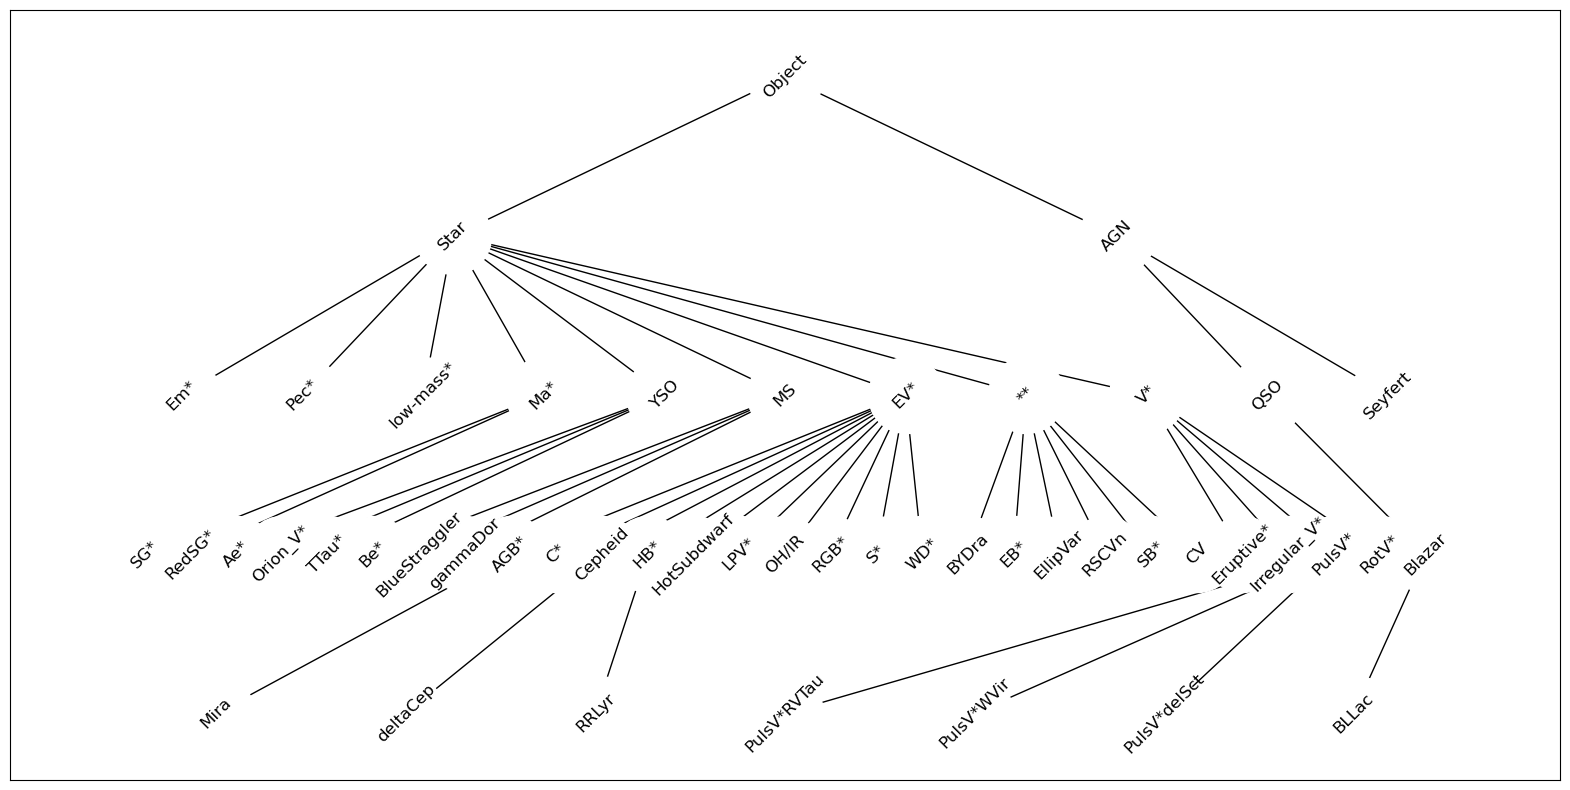

In [8]:
# Make a graph

G=nx.DiGraph()
G.add_edge('Object','Star')
G.add_edge('Object','AGN')

# AGN
G.add_edge('AGN','QSO')
G.add_edge('Blazar','BLLac')
G.add_edge('AGN','Seyfert')
G.add_edge('QSO','Blazar')

#rando stars
G.add_edge('Star','Em*')
G.add_edge('Star','Pec*')
G.add_edge('Star','low-mass*')

#Massive stars
G.add_edge('Star','Ma*')
G.add_edge('Ma*','SG*') 
G.add_edge('Ma*','RedSG*')

#Young stars
G.add_edge('Star','YSO') 
G.add_edge('YSO','Ae*')
G.add_edge('YSO','Orion_V*')
G.add_edge('YSO','TTau*')

#Main sequence
G.add_edge('Star','MS') 
G.add_edge('MS','Be*') 
G.add_edge('MS','BlueStraggler')
G.add_edge('MS','gammaDor')

#evolved stars
G.add_edge('Star','EV*')
G.add_edge('EV*','AGB*')
G.add_edge('AGB*','Mira')
G.add_edge('EV*','C*')
G.add_edge('EV*','Cepheid')
G.add_edge('EV*','HB*')
G.add_edge('EV*','HotSubdwarf')
G.add_edge('EV*','LPV*')
G.add_edge('EV*','OH/IR')
G.add_edge('EV*','RGB*')
G.add_edge('HB*','RRLyr')
G.add_edge('EV*','S*')
G.add_edge('EV*','WD*')
G.add_edge('Cepheid','deltaCep')

#binary...
G.add_edge('Star','**')
G.add_edge('**','BYDra')
G.add_edge('**','EB*')
G.add_edge('**','EllipVar')
G.add_edge('**','RSCVn')
G.add_edge('**','SB*')
G.add_edge('**','CV')


#variable - other
G.add_edge('Star','V*')
G.add_edge('V*','Eruptive*')
G.add_edge('V*','Irregular_V*')
G.add_edge('V*','PulsV*')
G.add_edge('PulsV*','PulsV*RVTau')
G.add_edge('PulsV*','PulsV*WVir')
G.add_edge('PulsV*','PulsV*delSct')
G.add_edge('V*','RotV*')

importlib.reload(hxetda)
pos = hxetda.hierarchy_pos(G, 'Object')

fig = plt.figure(1, figsize=(20, 10))

nx.draw_networkx(G, pos=pos, nodelist=vertices, node_color='white', with_labels=False, node_size=3000, arrows=False)
text = nx.draw_networkx_labels(G, pos)
for _, t in text.items():
    t.set_rotation(45) 

plt.show()


In [9]:
# Some pre-processing for the graph
paths, pathlengths, mask_list, y_dict = hxetda.calc_path_and_mask(G, vertices, 'Object')

In [10]:
# Some pre-processing for the class weights
importlib.reload(hxetda)

class_weight_dict = hxetda.calc_class_weights(labels, vertices, paths)

In [52]:
# Set up for train test split...
labels_new = [y_dict[x] for x in labels]
weights = [class_weight_dict[x] for x in labels]
X_train, X_test, y_train, y_test, labels_train, labels_test, weights_train, weights_test = train_test_split(all_features, labels_new, labels, weights,test_size=0.33, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

weights_train = torch.tensor(weights_train, dtype=torch.float32)
weights_test = torch.tensor(weights_test, dtype=torch.float32)

print(X_test)

tensor([[-0.3848, -0.4504, -0.4004,  ..., -0.2896, -0.4092, -0.3930],
        [-0.4367,  0.2136,  0.5156,  ...,  0.6962,  1.8442,  2.3244],
        [-0.4389, -0.2588,  0.4064,  ...,  0.5925,  0.6499,  0.6210],
        ...,
        [-0.4387, -0.5219,  2.4966,  ...,  0.5791, -0.2402, -0.2713],
        [-0.4390, -0.2307, -0.6705,  ...,  0.9367, -0.4092, -0.3930],
        [ 1.1548,  0.0246,  2.3469,  ..., -0.9785, -0.4092, -0.3930]])


1 -0.5661418 -0.4309585
11 -1.0126559 -0.87770206
21 -1.0777717 -0.93072927
31 -1.10341 -0.95414984
41 -1.1173081 -0.9644646
51 -1.1307008 -0.97218794
61 -1.1437212 -0.9760268
71 -1.154151 -0.9769834
81 -1.1639901 -0.9882213
91 -1.16898 -0.9903394
101 -1.1744819 -0.992424
111 -1.1835957 -0.99460864
121 -1.1893885 -0.9936532
131 -1.1855737 -0.99627745
141 -1.1912096 -0.99629444
151 -1.1940548 -0.99700713
161 -1.1985483 -0.99730635
171 -1.2004026 -0.9964153
181 -1.206823 -0.999187
191 -1.2114074 -0.99859583
201 -1.2139597 -1.0012159
211 -1.2186117 -1.0012696
221 -1.2185978 -1.0031022
231 -1.2228708 -1.0026636
241 -1.2243407 -1.0039262
251 -1.2231613 -1.0025164
261 -1.2313253 -1.0032259
271 -1.2282094 -1.0020716
281 -1.2339667 -1.0045128
291 -1.2243336 -1.0033858
301 -1.2344145 -1.0032929
311 -1.2312205 -1.005483
321 -1.2353873 -1.0050211
331 -1.2267913 -1.0015193
341 -1.2372553 -1.0000656
351 -1.2304076 -1.0005215
361 -1.2332656 -1.0026654
371 -1.2294942 -1.0025237
381 -1.2316204 -1.0015

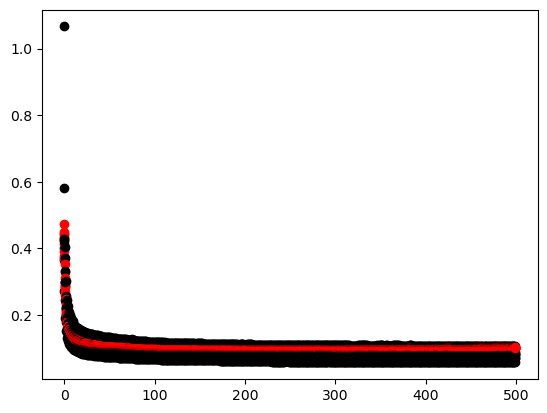

In [53]:
# Train!
model = hxetda.Feedforward(np.shape(X_test[0])[0],20, len(vertices))
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.1)
model.train()
epoch = 500
n_batches = 4096
loss=torch.tensor(0)
for epoch in range(epoch):
	if epoch%10==1:
		print(epoch, np.log10(loss.detach().numpy()), np.log10(loss2.detach().numpy()))
	for i in range(int(len(X_train)/n_batches)+1):
		# Local batches and labels
		local_X, local_y, local_weights = X_train[i*n_batches:(i+1)*n_batches,], y_train[i*n_batches:(i+1)*n_batches,], weights_train[i*n_batches:(i+1)*n_batches,]
		optimizer.zero_grad()
		# Forward pass
		y_pred = model(local_X)
		# Compute Loss
		loss = hxetda.custom_hier_loss(y_pred.to(torch.float),local_y.to(torch.float), local_weights, mask_list, pathlengths)
		# Backward pass
		loss.backward()
		optimizer.step()
		plt.plot(epoch,loss.detach().numpy(),'ko')
		ypred2 = model(X_test)
		loss2 = hxetda.custom_hier_loss(ypred2.to(torch.float),y_test.to(torch.float), weights_test, mask_list, pathlengths)
		plt.plot(epoch,loss2.detach().numpy(),'ro')
	
plt.show()

In [54]:
model.eval()
y_pred = model(X_test)


# leaf task

(15097, 35)
12246
(0.25572573403946974, 0.22877365098583796, 0.22957103175753185, None)
(0.8922913604442266, 0.8922913604442266, 0.8922913604442266, None)


/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


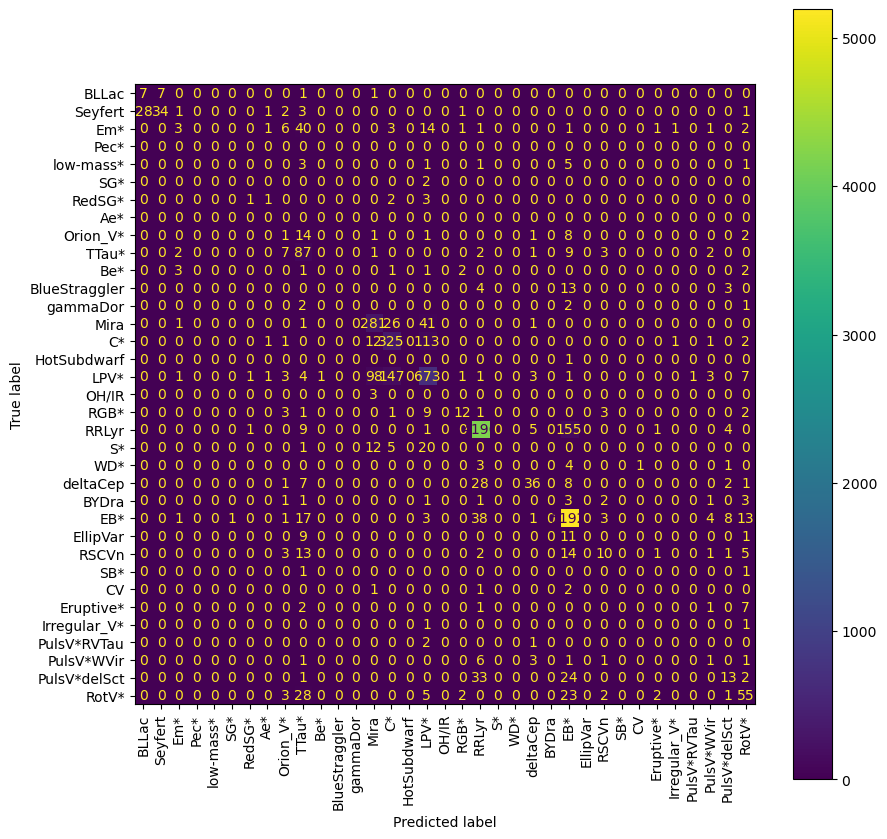

In [55]:
# 5-way task...
# Get my leaves...
leaves = np.asarray([x for x in G.nodes() if G.out_degree(x)==0 and G.in_degree(x)==1], dtype=str)

probs_list = np.zeros((len(y_pred), len(leaves)))
for i,leaf in enumerate(leaves):
    probs_list[:,i] = hxetda.get_prob(y_pred,leaf, paths, vertices, mask_list).detach().numpy()

my_predicted_types = leaves[np.argmax(probs_list,axis=1)]
print(np.shape(probs_list))

gind = np.where(np.in1d(labels_test,leaves))[0]
cm = confusion_matrix(labels_test[gind], my_predicted_types[gind], labels=leaves)
disp = ConfusionMatrixDisplay(cm, display_labels=leaves)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation='vertical', ax=ax)
print(len(gind))
print(precision_recall_fscore_support(labels_test[gind], my_predicted_types[gind],average='macro'))
print(precision_recall_fscore_support(labels_test[gind], my_predicted_types[gind],average='micro'))

12246


/var/folders/3g/dt9n1tgn3tb2py7t74lkz8y80000gn/T/ipykernel_22559/2142589040.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  baseline_ytest = torch.tensor(baseline_ytest)


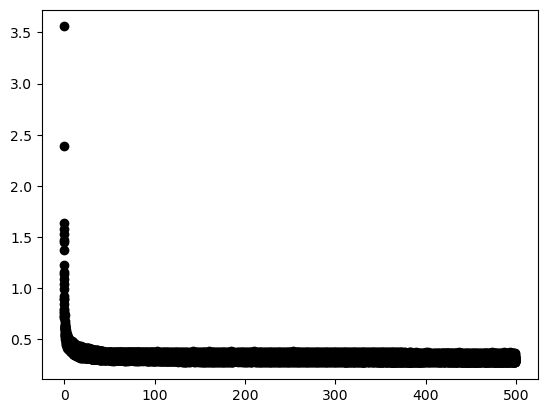

In [56]:
# Now for the same training/test set...train a baseline
# Train!

gind = np.where(np.in1d(labels_test,leaves))[0]
baseline_Xtest = X_test[gind]
baseline_ytest = y_test[gind]
baseline_labels_test = labels_test[gind]

print(len(gind))

gind = np.where(np.in1d(labels_train,leaves))[0]
baseline_Xtrain = X_train[gind]
baseline_ytrain = y_train[gind]
baseline_labels_train = labels_train[gind]

# Now only keep relevant columns...

new_baseline_ytest = np.zeros((len(baseline_ytest), len(leaves)))
new_baseline_ytrain = np.zeros((len(baseline_ytrain), len(leaves)))

for i,leaf in enumerate(leaves):
    j = np.where(leaf == vertices)[0][0]
    new_baseline_ytrain[:,i] = baseline_ytrain[:,j]
    new_baseline_ytest[:,i] = baseline_ytest[:,j]

baseline_ytrain = torch.tensor(new_baseline_ytrain)
baseline_ytest = torch.tensor(baseline_ytest)

model_baseline = hxetda.Feedforward(np.shape(X_test[0])[0],15, len(leaves))
optimizer = torch.optim.AdamW(model_baseline.parameters(), lr = 0.1)
model_baseline.train()
epoch = 500
n_batches = 1024


#class_weights=class_weight.compute_class_weight('balanced',classes=np.unique(labels_test),y=my_predicted_types)

myloss = torch.nn.CrossEntropyLoss()

for epoch in range(epoch):
	for i in range(int(len(baseline_Xtrain)/n_batches)+1):
		# Local batches and labels
		local_X, local_y = baseline_Xtrain[i*n_batches:(i+1)*n_batches,], baseline_ytrain[i*n_batches:(i+1)*n_batches,]
		optimizer.zero_grad()
		# Forward pass
		y_pred_baseline = model_baseline(local_X)
		# Compute Loss
		loss = myloss(y_pred_baseline,local_y)
		# Backward pass
		loss.backward()
		optimizer.step()
		plt.plot(epoch,loss.detach().numpy(),'ko')
	#scheduler.step()
plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.28115590166691135, 0.23920583415074692, 0.24737063016437377, None)
(0.8992324024171158, 0.8992324024171158, 0.8992324024171158, None)


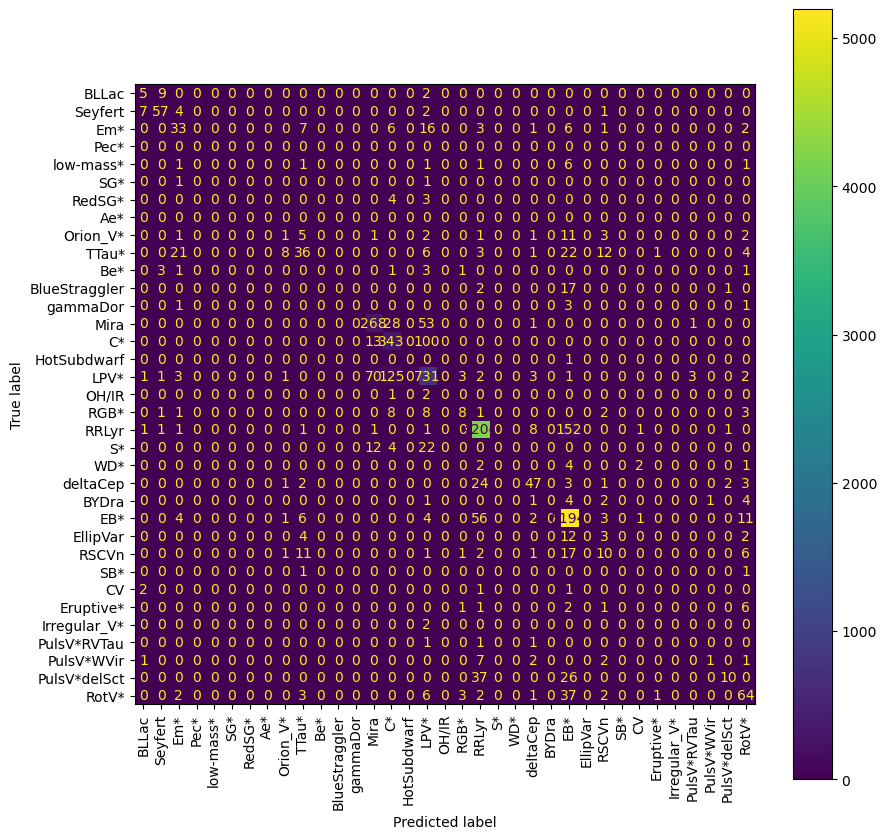

In [57]:
model_baseline.eval()
y_pred_baseline = model_baseline(baseline_Xtest).detach().numpy()
predicted_baseline_types = leaves[np.argmax(y_pred_baseline,axis=1)]
cm = confusion_matrix(baseline_labels_test, predicted_baseline_types, labels=leaves)
disp = ConfusionMatrixDisplay(cm, display_labels=leaves)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation='vertical', ax=ax)

print(precision_recall_fscore_support(baseline_labels_test, predicted_baseline_types,average='macro'))
print(precision_recall_fscore_support(baseline_labels_test, predicted_baseline_types,average='micro'))

# Sibling task

(0.9901724179918662, 0.9401168079207228, 0.96376455046393, None)
(0.9983440418626217, 0.9983440418626217, 0.9983440418626217, None)


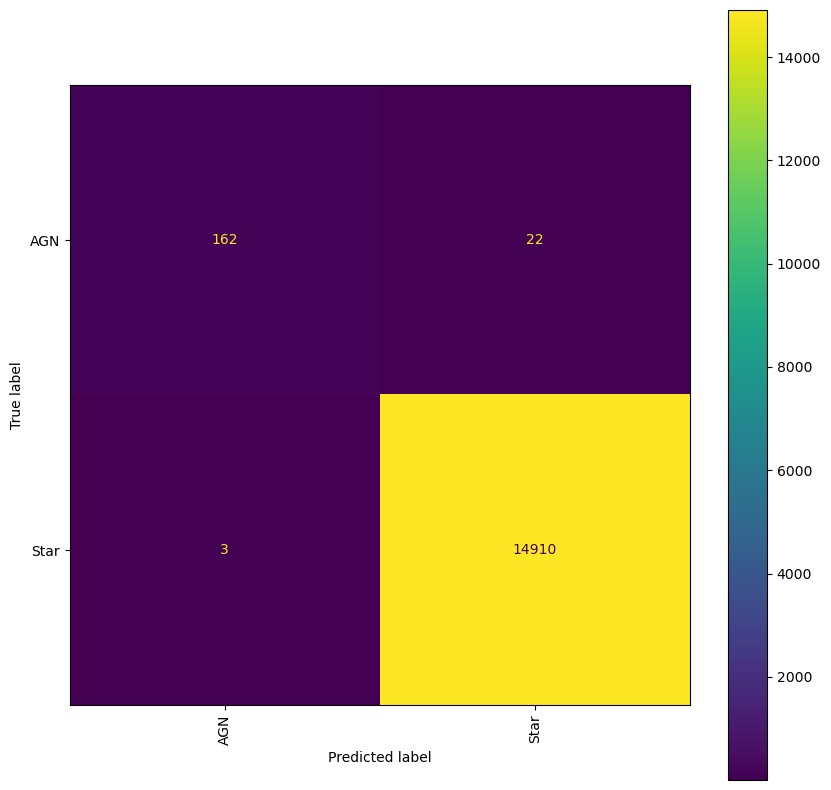

In [58]:
importlib.reload(hxetda)

siblings = np.asarray(['AGN', 'Star'])
probs_list = np.zeros((len(y_pred), len(siblings)))
for i,sib in enumerate(siblings):
    probs_list[:,i] = hxetda.get_prob(y_pred,sib, paths, vertices, mask_list).detach().numpy()

my_predicted_types = siblings[1*(probs_list[:,0]<0.5)]

sibling_labels_test = np.copy(labels_test)
for i,s in enumerate(sibling_labels_test):
    is_AGN = hxetda.is_parent(s, 'AGN', vertices, paths)
    if is_AGN:
        sibling_labels_test[i] = 'AGN'
    else:
        sibling_labels_test[i] = 'Star'

cm = confusion_matrix(sibling_labels_test, my_predicted_types, labels=siblings)
disp = ConfusionMatrixDisplay(cm, display_labels=siblings)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation='vertical', ax=ax)

print(precision_recall_fscore_support(sibling_labels_test, my_predicted_types,average='macro'))
print(precision_recall_fscore_support(sibling_labels_test, my_predicted_types,average='micro'))

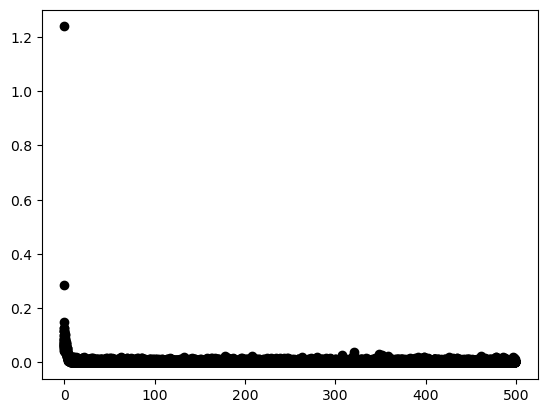

In [59]:
# And now baseline...
# Now for the same training/test set...train a baseline
# Train!

siblings = np.asarray(['AGN', 'Star'])

baseline_ytest = np.zeros((len(y_test), len(siblings)))
sibling_labels_test = np.copy(labels_test)
for i,s in enumerate(sibling_labels_test):
    is_AGN = hxetda.is_parent(s, 'AGN', vertices, paths)
    if is_AGN:
        sibling_labels_test[i] = 'AGN'
        baseline_ytest[i,0] = 1
    else:
        sibling_labels_test[i] = 'Star'
        baseline_ytest[i,1] = 1

baseline_ytrain = np.zeros((len(y_train), len(siblings)))
sibling_labels_train = np.copy(labels_train)
for i,s in enumerate(sibling_labels_train):
    is_AGN = hxetda.is_parent(s, 'AGN', vertices, paths)
    if is_AGN:
        sibling_labels_train[i] = 'AGN'
        baseline_ytrain[i,0] = 1
    else:
        sibling_labels_train[i] = 'Star'
        baseline_ytrain[i,1] = 1

baseline_ytrain = torch.tensor(baseline_ytrain)
baseline_ytest = torch.tensor(baseline_ytest)

model_baseline = hxetda.Feedforward(np.shape(X_test[0])[0],15, len(siblings))
optimizer = torch.optim.AdamW(model_baseline.parameters(), lr = 0.1)
model_baseline.train()
epoch = 500
n_batches = 1024

baseline_Xtrain = torch.tensor(np.copy(X_train))
baseline_Xtest = torch.tensor(np.copy(X_test))


myloss = torch.nn.CrossEntropyLoss()

for epoch in range(epoch):
	for i in range(int(len(baseline_Xtrain)/n_batches)+1):
		# Local batches and labels
		local_X, local_y = baseline_Xtrain[i*n_batches:(i+1)*n_batches,], baseline_ytrain[i*n_batches:(i+1)*n_batches,]
		optimizer.zero_grad()
		# Forward pass
		y_pred_baseline = model_baseline(local_X)
		# Compute Loss
		loss = myloss(y_pred_baseline,local_y)
		# Backward pass
		loss.backward()
		optimizer.step()
		plt.plot(epoch,loss.detach().numpy(),'ko')
	#scheduler.step()
plt.show()

(0.9799013926137472, 0.9644392184816866, 0.9720404800955331, None)
(0.9986752334900973, 0.9986752334900973, 0.9986752334900973, None)


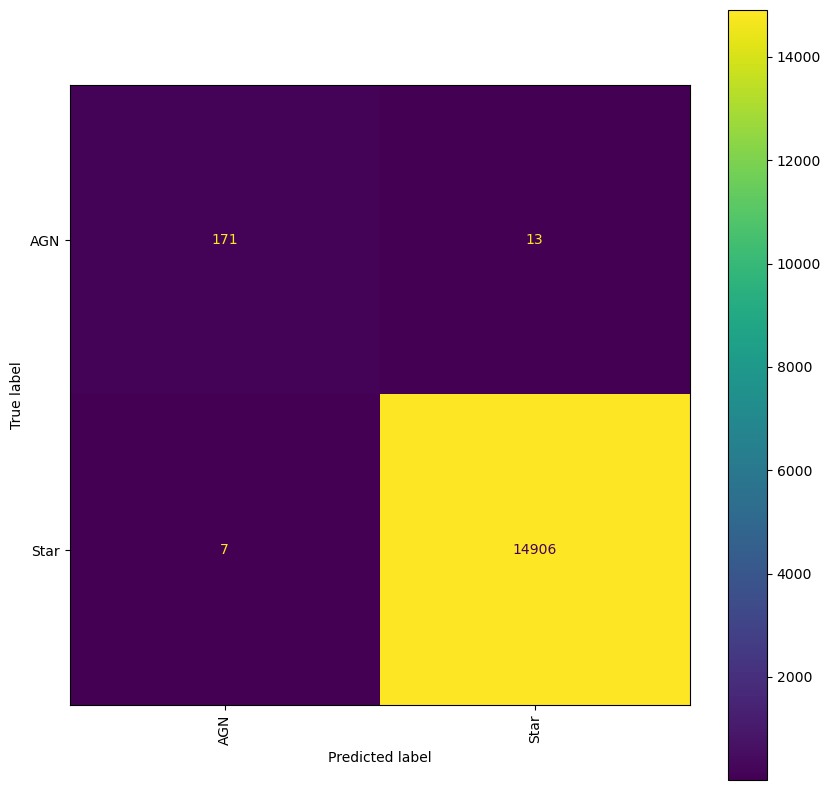

In [60]:
model_baseline.eval()
y_pred_baseline = model_baseline(baseline_Xtest).detach().numpy()
predicted_baseline_types = siblings[np.argmax(y_pred_baseline,axis=1)]
cm = confusion_matrix(sibling_labels_test, predicted_baseline_types, labels=siblings)
disp = ConfusionMatrixDisplay(cm, display_labels=siblings)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation='vertical', ax=ax)

print(precision_recall_fscore_support(sibling_labels_test, predicted_baseline_types,average='macro'))
print(precision_recall_fscore_support(sibling_labels_test, predicted_baseline_types,average='micro'))